# Time Series Forecast
## Ce qui rend les séries chronologiques spéciales

Comme son nom l'indique, TS est une collection de points de données collectés à intervalles de temps constants. Ceux-ci sont analysés pour déterminer la tendance à long terme afin de prévoir l'avenir ou d'effectuer une autre forme d'analyse. Mais en quoi un TS est-il différent d'un problème de régression ordinaire ? Il y a deux choses :
- Elle dépend du temps. L'hypothèse de base d'un modèle de régression linéaire selon laquelle les observations sont indépendantes ne tient donc pas dans ce cas.
- En plus d'une tendance à la hausse ou à la baisse, la plupart des TS présentent une certaine forme de tendances saisonnières, c'est-à-dire des variations spécifiques à une période donnée. Par exemple, si vous observez les ventes d'une veste en laine au fil du temps, vous trouverez invariablement des ventes plus élevées pendant les saisons d'hiver.
## Comment vérifier la stationnarité d'une série chronologique

Une TS est dite stationnaire si ses propriétés statistiques telles que la moyenne, la variance restent constantes dans le temps. Mais pourquoi est-ce important ? La plupart des modèles d'AT fonctionnent sur l'hypothèse que l'AT est stationnaire. Intuitivement, on peut dire que si un TS a un comportement particulier dans le temps, il y a une très forte probabilité qu'il suive le même chemin dans le futur. De plus, les théories liées aux séries stationnaires sont plus matures et plus faciles à mettre en œuvre que les séries non stationnaires.
La stationnarité est définie à l'aide de critères très stricts. Cependant, à des fins pratiques, nous pouvons supposer que la série est stationnaire si elle présente des propriétés statistiques constantes dans le temps, c'est-à-dire les suivantes :
- moyenne constante
- une variance constante
- une autocovariance qui ne dépend pas du temps.


- **Tracer des statistiques mobiles :** Nous pouvons tracer la moyenne mobile ou la variance mobile et voir si elle varie dans le temps. Par moyenne/variance mobile, je veux dire qu'à tout instant 't', nous prenons la moyenne/variance de l'année précédente, c'est-à-dire des 12 derniers mois. Mais là encore, il s'agit plutôt d'une technique visuelle.
- **Test de Dickey-Fuller :** C'est l'un des tests statistiques permettant de vérifier la stationnarité. Ici, l'hypothèse nulle est que le TS n'est pas stationnaire. Les résultats du test comprennent une statistique de test et des valeurs critiques pour les différents niveaux de confiance. Si la 'Statistique de test' est inférieure à la 'Valeur critique', nous pouvons rejeter l'hypothèse nulle et dire que la série est stationnaire.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
#!pip install statsmodels

from statsmodels.tsa.stattools import adfuller


In [2]:
data = pd.read_csv("AirPassengers.csv",index_col= 'Month')

In [3]:
df = data.copy()
df.columns = ['Passengers']

In [4]:
df.index = df.index +'-01'

df.index[0]

'1949-01-01'

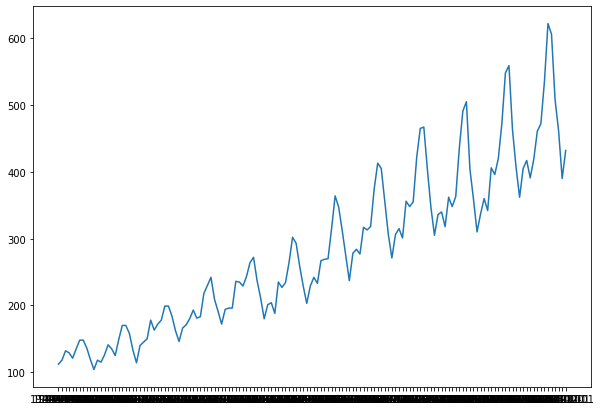

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(df['Passengers'])

Back to checking stationarity, we’ll be using the rolling statistics plots along with Dickey-Fuller test results a lot so I have defined a function which takes a TS as input and generated them for us. Please note that I’ve plotted standard deviation instead of variance to keep the unit similar to mean.

In [6]:
def test_stationarity(timeseries, ww):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=ww).mean()
    rolstd = pd.Series(timeseries).rolling(window=ww).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

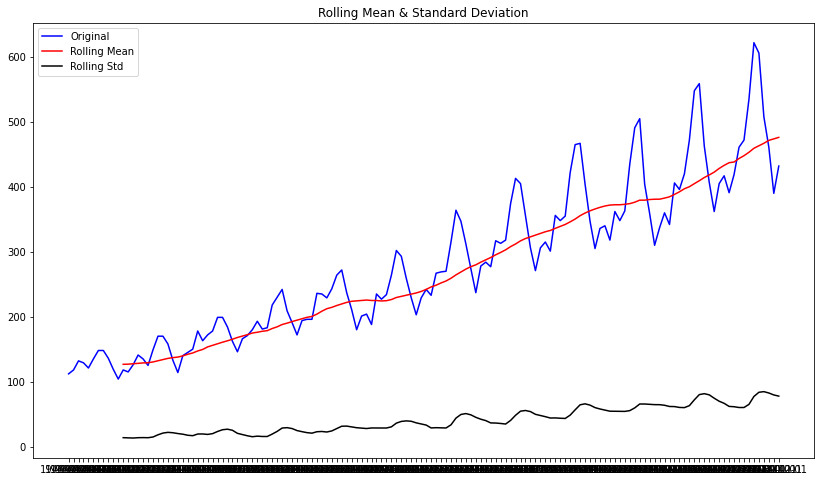

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
plt.figure(figsize=(14, 8))

test_stationarity(df['Passengers'], 12)

Bien que la variation de l'écart-type soit faible, la moyenne augmente clairement avec le temps et il ne s'agit pas d'une série stationnaire. De plus, la statistique de test est bien supérieure aux valeurs critiques. Notez que les valeurs signées doivent être comparées et non les valeurs absolues.

## Comment rendre une série temporelle stationnaire ?

Bien que l'hypothèse de stationnarité soit prise en compte dans de nombreux modèles TS, presque aucune série chronologique pratique n'est stationnaire. Les statisticiens ont donc trouvé des moyens de rendre les séries stationnaires, dont nous allons parler maintenant. En fait, il est presque impossible de rendre une série parfaitement stationnaire, mais nous essayons de nous en approcher le plus possible.

Comprenons ce qui rend un TS non stationnaire. Il y a 2 raisons majeures derrière la non-stationnarité d'un TS :

1. **Tendance** - moyenne variable dans le temps. Par exemple, dans ce cas, nous avons vu qu'en moyenne, le nombre de passagers augmentait au fil du temps.
2. **Saisonnalité** - variations à des périodes spécifiques. Par exemple, les gens peuvent avoir tendance à acheter des voitures au cours d'un mois particulier en raison des augmentations de salaire ou des festivals.

Le principe sous-jacent est de modéliser ou d'estimer la tendance et la saisonnalité de la série et de les éliminer de la série pour obtenir une série stationnaire. Ensuite, des techniques de prévision statistique peuvent être mises en œuvre sur cette série. L'étape finale consisterait à convertir les valeurs prévues dans l'échelle originale en réappliquant les contraintes de tendance et de saisonnalité.

## Estimation et élimination de la tendance

L'une des premières astuces pour réduire la tendance peut être la transformation. Par exemple, dans ce cas, nous pouvons clairement voir qu'il y a une tendance positive significative. Nous pouvons donc appliquer une transformation qui pénalise davantage les valeurs élevées que les valeurs faibles. Il peut s'agir d'une transformation en logarithme, en racine carrée, en racine cubique, etc. Pour simplifier, prenons une transformation logarithmique :


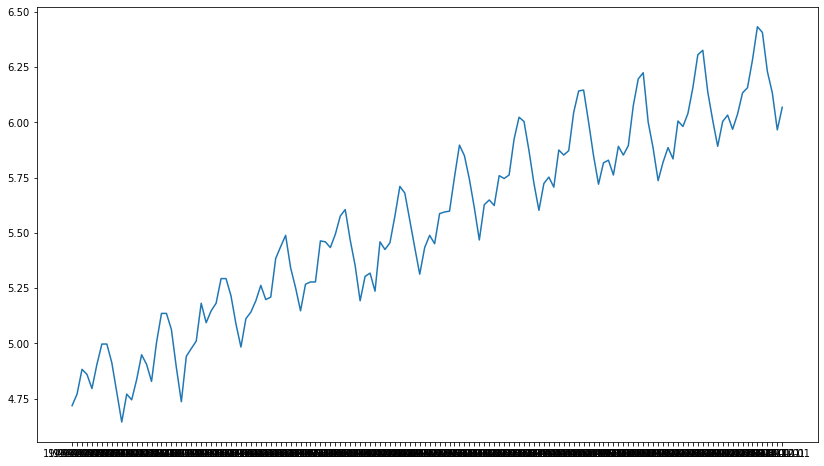

In [8]:
plt.figure(figsize=(14, 8))

df_log = np.log(df)
plt.plot(df_log)

Dans ce cas plus simple, il est facile de voir une tendance vers l'avant dans les données. Mais ce n'est pas très intuitif en présence de bruit. Nous pouvons donc utiliser certaines techniques pour estimer ou modéliser cette tendance, puis la supprimer de la série. Il existe de nombreuses façons de procéder et certaines des plus courantes sont les suivantes :

- **Agrégation (Aggregation)**- prendre la moyenne pour une période de temps comme les moyennes mensuelles/hebdomadaires.
- **Lissage (Smoothing)**- prise de moyennes mobiles
- **Ajustement polynomial (Polynomial Fitting)**- ajustement d'un modèle de régression.

Je traiterai ici du lissage, mais vous devriez également essayer d'autres techniques qui pourraient s'avérer utiles pour d'autres problèmes. Le lissage consiste à prendre des estimations glissantes, c'est-à-dire à prendre en compte les dernières instances. Il existe plusieurs façons de procéder, mais je vais en aborder deux ici.

## Moyenne mobile

Dans cette approche, nous prenons la moyenne de "k" valeurs consécutives en fonction de la fréquence de la série chronologique. Ici, nous pouvons prendre la moyenne sur les 1 dernières années, c'est-à-dire les 12 dernières valeurs. Pandas dispose de fonctions spécifiques définies pour déterminer les statistiques glissantes.

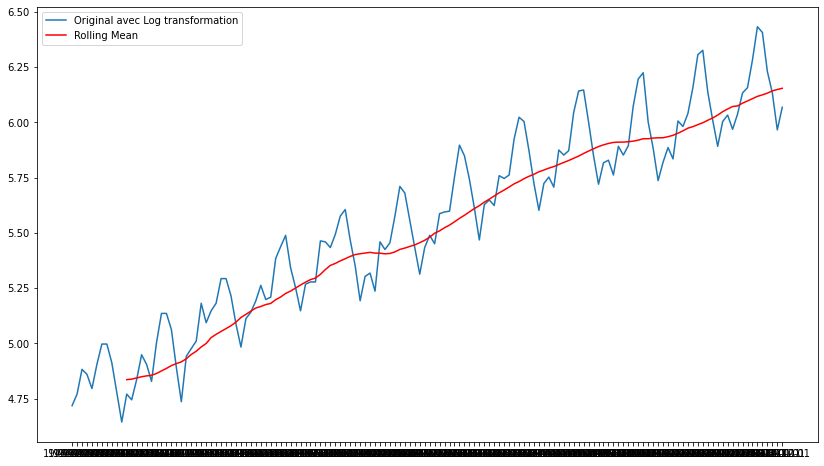

In [9]:
moving_avg = pd.Series(df_log['Passengers']).rolling(window=12).mean()

plt.figure(figsize=(14,8))
plt.plot(df_log, label='Original avec Log transformation')
plt.plot(moving_avg, color='red', label='Rolling Mean')
plt.legend()
plt.show()

In [10]:
moving_avg = pd.DataFrame(moving_avg)

La ligne rouge montre la moyenne mobile. Soustrayons-la de la série originale. Notez que puisque nous prenons la moyenne des 12 dernières valeurs, la moyenne mobile n'est pas définie pour les 11 premières valeurs. Ceci peut être observé comme :

In [11]:
df_log_moving_avg_diff = df_log - moving_avg

df_log_moving_avg_diff

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,0.282363
1960-09-01,0.098235
1960-10-01,-0.009230


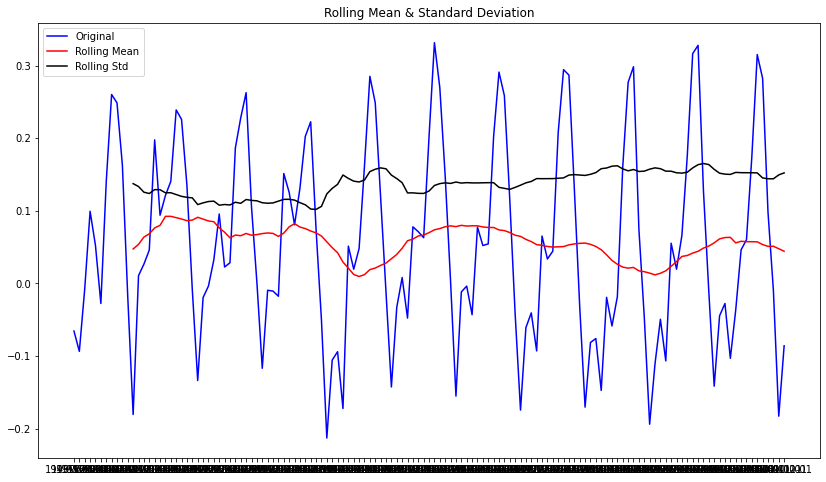

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [12]:
df_log_moving_avg_diff = df_log_moving_avg_diff.dropna()

plt.figure(figsize=(14, 8))
test_stationarity(df_log_moving_avg_diff['Passengers'], 12)


 Cette série semble bien meilleure. Les valeurs de roulement semblent varier légèrement mais il n'y a pas de tendance spécifique. En outre, la statistique de test est inférieure aux valeurs critiques de 5 %, ce qui nous permet d'affirmer avec 95 % de confiance qu'il s'agit d'une série stationnaire.

## exponentially weighted moving average
 Cependant, l'inconvénient de cette approche particulière est que la période de temps doit être strictement définie. Dans ce cas, nous pouvons prendre des moyennes annuelles, mais dans des situations complexes comme la prévision du cours d'une action, il est difficile de trouver un chiffre. Nous utilisons donc une "moyenne mobile pondérée" dans laquelle les valeurs les plus récentes ont un poids plus important. Il existe de nombreuses techniques pour attribuer des pondérations. L'une d'entre elles, très répandue, est la moyenne mobile pondérée de manière exponentielle, où des pondérations sont attribuées à toutes les valeurs précédentes avec un facteur de décroissance. 

In [13]:
expwighted_avg24 = df_log['Passengers'].ewm(span=24, adjust=False).mean()
expwighted_avg12 = df_log['Passengers'].ewm(span=12, adjust=False).mean()
expwighted_avg6 = df_log['Passengers'].ewm(span=6, adjust=False).mean()
expwighted_avg3 = df_log['Passengers'].ewm(span=3, adjust=False).mean()

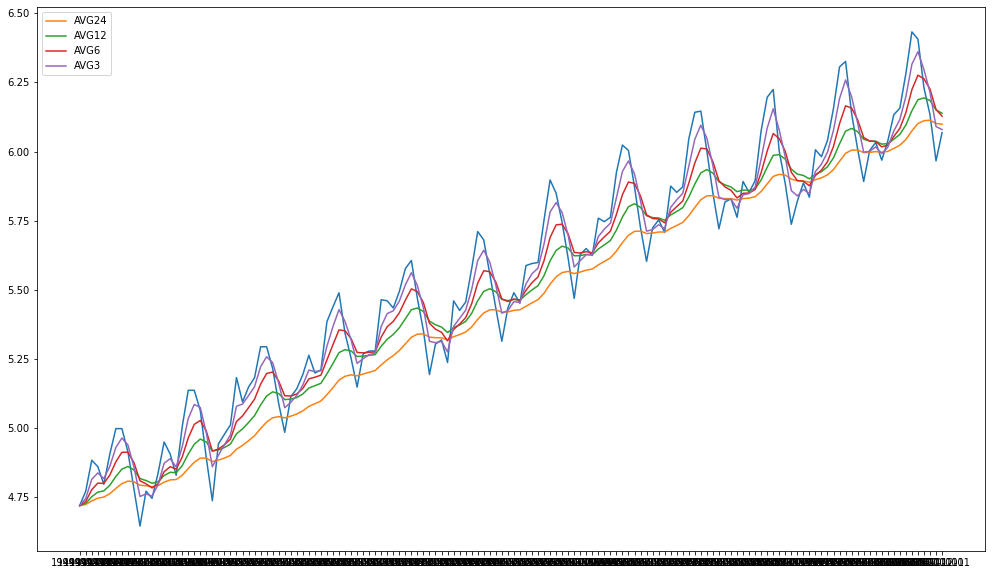

In [14]:
plt.figure(figsize=(17, 10))

plt.plot(df_log['Passengers'])
plt.plot(expwighted_avg24, label = 'AVG24')
plt.plot(expwighted_avg12, label = 'AVG12')
plt.plot(expwighted_avg6, label='AVG6')
plt.plot(expwighted_avg3, label='AVG3')
plt.legend()
plt.show()

Notez qu'ici, le paramètre "demi-vie" est utilisé pour définir le degré de décroissance exponentielle. Il ne s'agit que d'une hypothèse et cela dépend largement du domaine d'activité. D'autres paramètres tels que la portée et le centre de masse peuvent également être utilisés pour définir la décroissance, qui sont discutés dans le lien partagé ci-dessus. Maintenant, supprimons ceci de la série et vérifions la stationnarité :

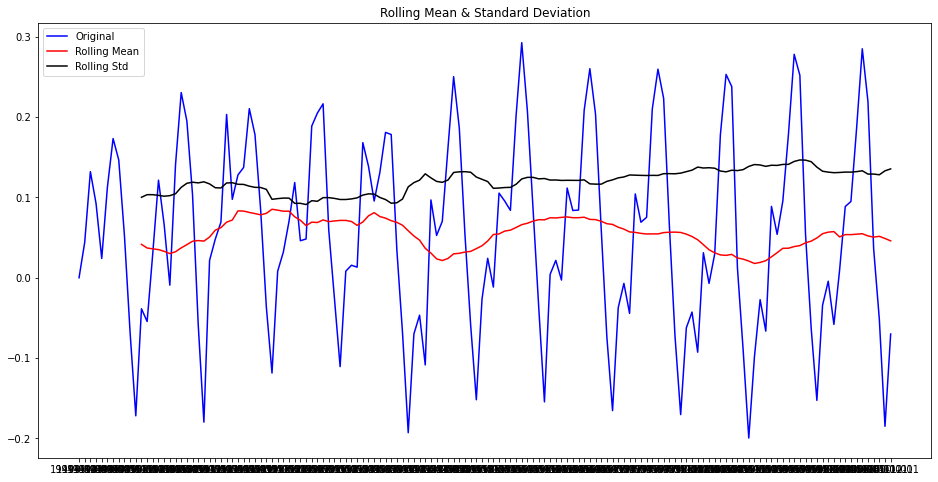

Results of Dickey-Fuller Test:
Test Statistic                  -2.748983
p-value                          0.065939
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [15]:
ts_log_ewma_diff = df_log['Passengers'] - pd.DataFrame(expwighted_avg12)['Passengers']

plt.figure(figsize=(16, 8))
test_stationarity(ts_log_ewma_diff, 12)

Cette TS présente des variations de moyenne et d'écart-type d'ampleur encore plus faible. De plus, la statistique de test est inférieure à la valeur critique de 1%, ce qui est mieux que le cas précédent. Notez que dans ce cas, il n'y aura pas de valeurs manquantes car toutes les valeurs de départ sont pondérées. Cela fonctionnera donc même en l'absence de valeurs précédentes.

## Élimination de la tendance et de la saisonnalité
Les techniques simples de réduction des tendances évoquées précédemment ne fonctionnent pas dans tous les cas, en particulier ceux qui présentent une forte saisonnalité. Examinons deux façons d'éliminer la tendance et la saisonnalité :

- **Différenciation** - prendre la différence avec un décalage temporel particulier.
- **Décomposition** - modéliser à la fois la tendance et la saisonnalité et les supprimer du modèle.

### Differencing
L'une des méthodes les plus courantes pour traiter à la fois la tendance et la saisonnalité est la différenciation. Dans cette technique, nous prenons la différence de l'observation à un instant particulier avec celle de l'instant précédent. Cette méthode fonctionne généralement bien pour améliorer la stationnarité.

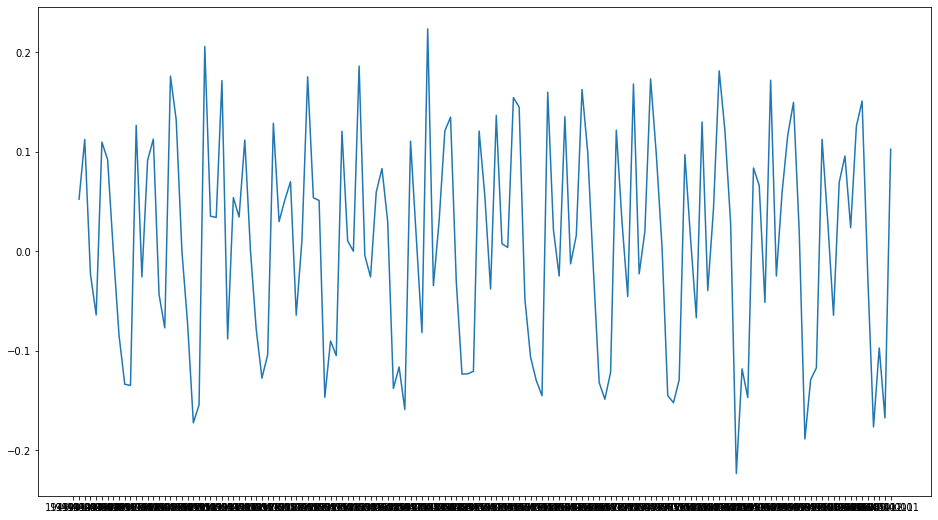

In [16]:
df_log_diff = df_log['Passengers'] - df_log.shift()['Passengers']

plt.figure(figsize=(16, 9))
plt.plot(df_log_diff)
plt.show()

In [17]:
df_log_diff=df_log_diff.dropna()

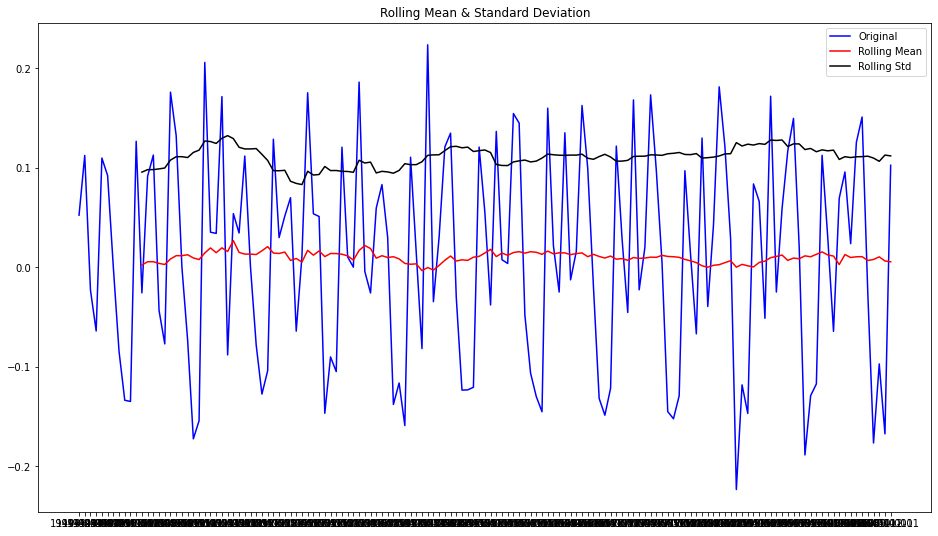

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [18]:
# df_log_diff.dropna(inplace=True)
plt.figure(figsize=(16, 9))
test_stationarity(df_log_diff, 12)

Nous pouvons voir que la moyenne et l'écart-type ont de faibles variations dans le temps. De plus, la statistique du test de Dickey-Fuller est inférieure à la valeur critique de 10%, donc l'ET est stationnaire avec une confiance de 90%. Nous pouvons également prendre des différences de deuxième ou troisième ordre qui pourraient obtenir des résultats encore meilleurs dans certaines applications. Je vous laisse le soin de les essayer.

## Décomposition
Dans cette approche, la tendance et la saisonnalité sont modélisées séparément et la partie restante de la série est restituée.

In [19]:
df_log.index = pd.to_datetime(df.index)

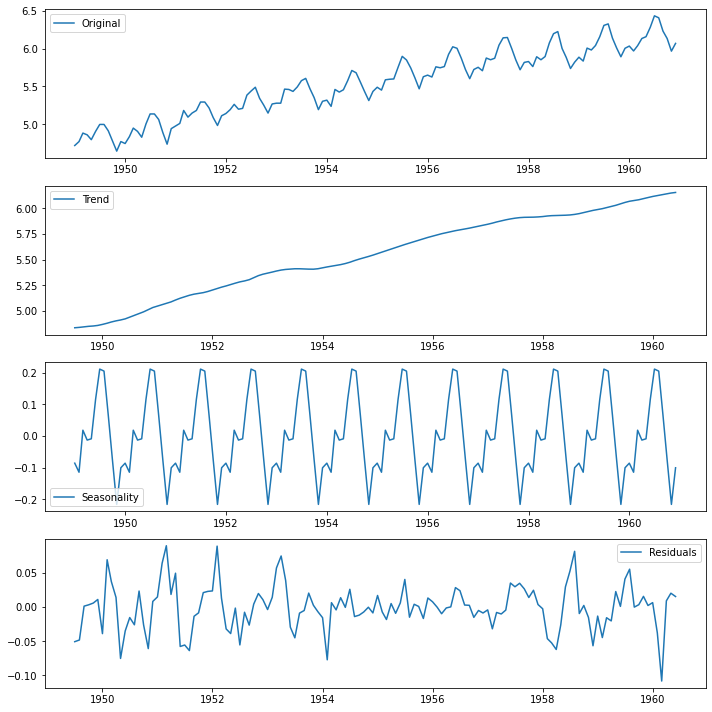

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Forecasting a Time Series

Nous avons vu différentes techniques et toutes ont fonctionné raisonnablement bien pour rendre le TS stationnaire. Faisons un modèle sur le TS après différenciation car c'est une technique très populaire. De plus, il est relativement plus facile de réintégrer le bruit et la saisonnalité dans les résidus prédits dans ce cas. Après avoir effectué les techniques d'estimation de la tendance et de la saisonnalité, il peut y avoir deux situations :

- Une série strictement stationnaire, sans dépendance entre les valeurs. C'est le cas le plus simple où nous pouvons modéliser les résidus comme un bruit blanc. Mais cette situation est très rare.
- Une série avec une dépendance significative entre les valeurs. Dans ce cas, nous devons utiliser des modèles statistiques comme ARIMA pour prévoir les données.

## l'ARIMA.

http://people.duke.edu/~rnau/411arim3.htm
https://otexts.com/fpp2/arima-r.html




Je ne vais pas entrer dans les détails techniques, mais vous devez comprendre ces concepts en détail si vous souhaitez les appliquer plus efficacement. ARIMA est l'abréviation de Auto-Regressive Integrated Moving Averages. La prévision ARIMA pour une série chronologique stationnaire n'est rien d'autre qu'une équation linéaire (comme une régression linéaire). Les prédicteurs dépendent des paramètres (p, d, q) du modèle ARIMA :

- **Le nombre de termes AR (Auto-Regressive) (p)** : Les termes AR sont simplement des retards de la variable dépendante. Par exemple, si p est 5, les prédicteurs de x(t) seront x(t-1)....x(t-5).
- **Nombre de termes MA (Moving Average) (q)** : Les termes MA sont des erreurs de prévision décalées dans l'équation de prédiction. Par exemple, si q est égal à 5, les prédicteurs de x(t) seront e(t-1)....e(t-5) où e(i) est la différence entre la moyenne mobile au ième instant et la valeur réelle.
- **Nombre de différences (d)** : Il s'agit du nombre de différences non saisonnières, c'est-à-dire que dans ce cas, nous avons pris la différence de premier ordre. Donc, nous pouvons soit passer cette variable et mettre d=0, soit passer la variable originale et mettre d=1. Les deux produiront les mêmes résultats.

Il est important de savoir comment déterminer la valeur de 'p' et 'q'. Nous utilisons deux graphiques pour déterminer ces nombres. Discutons-en d'abord.

- **Fonction d'autocorrélation (ACF)** : Il s'agit d'une mesure de la corrélation entre le TS et une version décalée de lui-même. Par exemple, à un retard de 5, l'ACF compare la série à l'instant 't1'...'t2' avec la série à l'instant 't1-5'...'t2-5' (t1-5 et t2 étant les points finaux).
- **Fonction d'autocorrélation partielle (PACF)** : Elle mesure la corrélation entre la TS avec une version décalée d'elle-même mais après avoir éliminé les variations déjà expliquées par les comparaisons intermédiaires. Par exemple, au retard 5, elle vérifiera la corrélation mais éliminera les effets déjà expliqués par les retards 1 à 4.

Les graphiques ACF et PACF pour le TS après différenciation peuvent être tracés comme suit :

In [21]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [22]:
lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

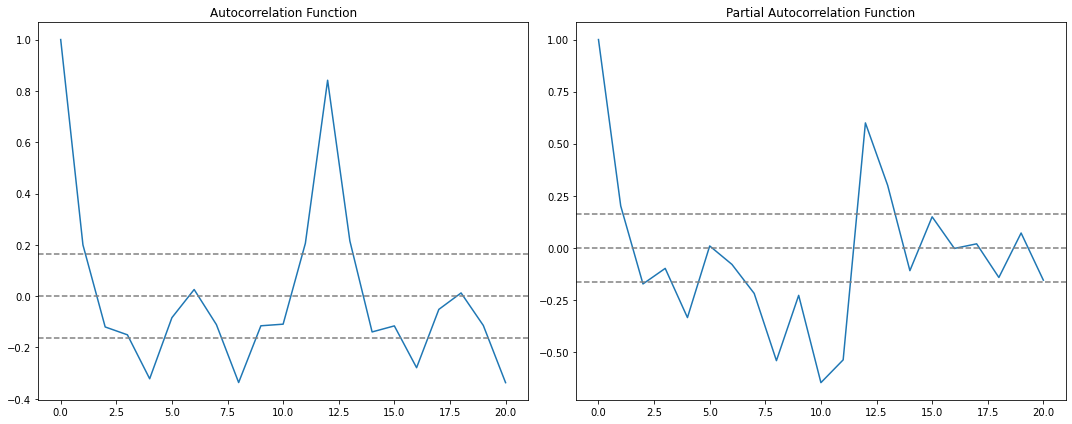

In [23]:
#Plot ACF: 
plt.figure(figsize=(15, 6))
plt.subplot(121) 

plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122) 

plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Dans ce graphique, les deux lignes en pointillés de part et d'autre de 0 sont les intervalles de confiance. Elles peuvent être utilisées pour déterminer les valeurs 'p' et 'q' comme suit :

- p - La valeur du décalage (The lag value) où le graphique PACF croise l'intervalle de confiance supérieur pour la première fois. Si vous observez bien, dans ce cas, p=2.
- q - La valeur de décalage (The lag value) où le graphique ACF croise l'intervalle de confiance supérieur pour la première fois. Si vous remarquez bien, dans ce cas, q=2.

Maintenant, faisons 3 modèles ARIMA différents en considérant les effets individuels ainsi que les effets combinés. Je vais également imprimer le RSS pour chacun. Veuillez noter qu'ici le RSS est pour les valeurs des résidus et non pour les séries réelles.

### Qu'est-ce que la somme résiduelle des carrés (RSS) ?

La somme résiduelle des carrés (RSS) est une technique statistique utilisée pour mesurer la quantité de variance dans un ensemble de données qui n'est pas expliquée par le modèle de régression lui-même. Au lieu de cela, elle estime la variance des résidus, ou terme d'erreur.

**COMPRÉHENSIONS CLÉS**


- La somme des carrés résiduels (RSS) mesure le niveau de variance du terme d'erreur, ou résidus, d'un modèle de régression.
- Plus la somme des carrés résiduels est petite, mieux votre modèle s'adapte à vos données ; plus la somme des carrés résiduels est grande, moins votre modèle s'adapte à vos données. 
- Une valeur de zéro signifie que votre modèle est parfaitement ajusté.
- Les modèles statistiques sont utilisés par les investisseurs et les gestionnaires de portefeuille pour suivre le cours d'un investissement et utiliser ces données pour prédire les mouvements futurs.
- Le RSS est utilisé par les analystes financiers afin d'estimer la validité de leurs modèles économétriques.


In [24]:
from statsmodels.tsa.arima.model import ARIMA

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

## AR Model


/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 1.5023')

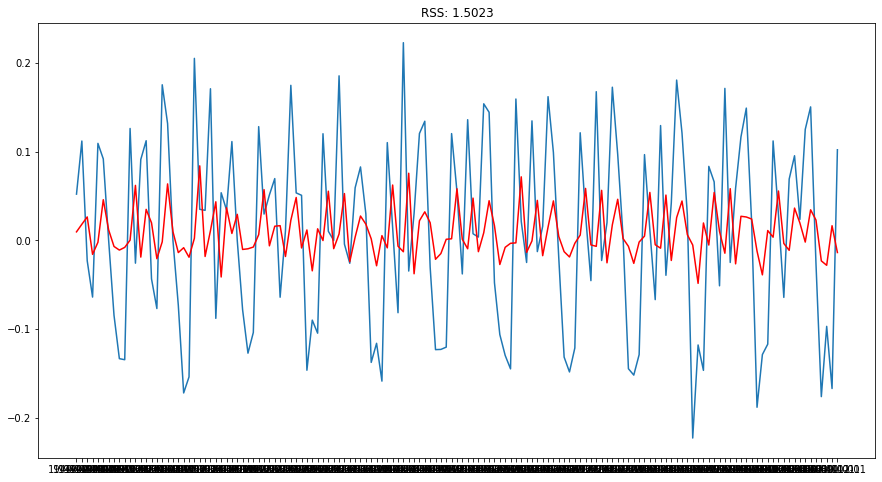

In [25]:
model = ARIMA(df_log_diff, order=(2, 0, 0))  
results_AR = model.fit()  


plt.figure(figsize = (15, 8))
plt.plot(df_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df_log_diff)**2))

## MA model

/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 1.4721')

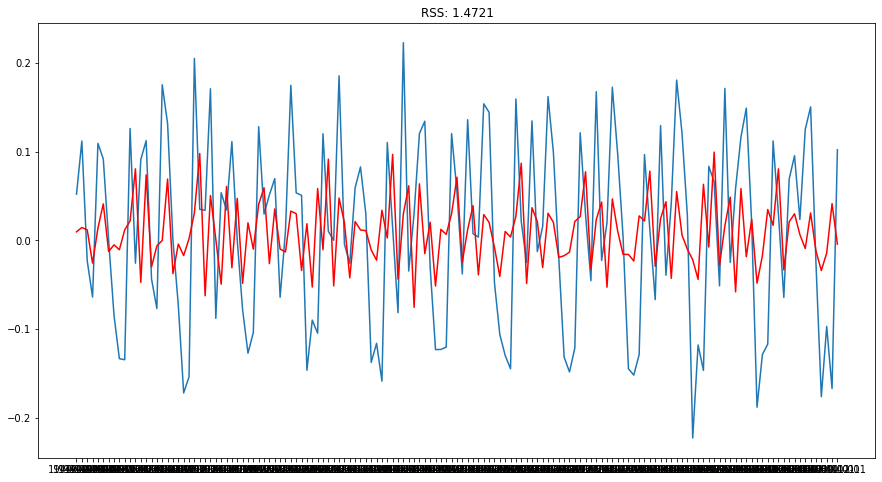

In [26]:
model = ARIMA(df_log_diff, order=(0, 0, 2))  
results_MA = model.fit()  

plt.figure(figsize = (15, 8))
plt.plot(df_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-df_log_diff)**2))

## Combined Model

/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/omar/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/omar/.local/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS: 1.5053')

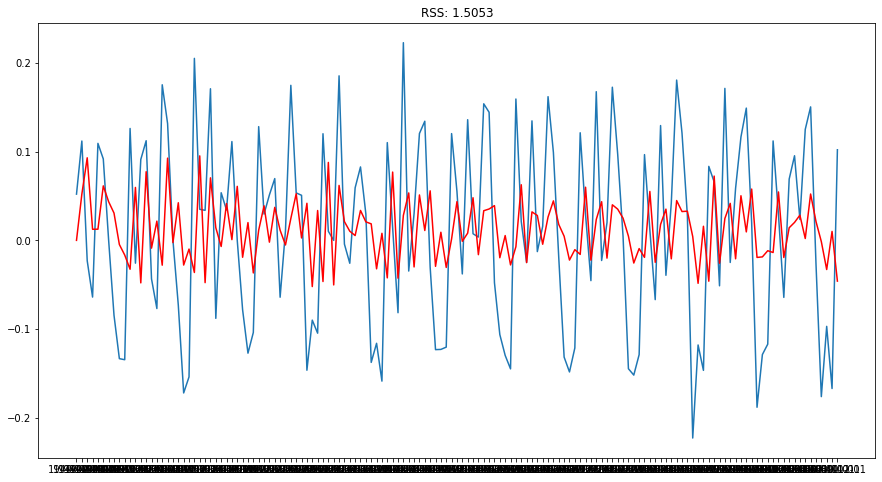

In [27]:
model = ARIMA(df_log_diff, order=(2, 1, 2))  
results_ARIMA = model.fit()  

plt.figure(figsize = (15, 8))
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df_log_diff)**2))

Ici, nous pouvons voir que les modèles AR et MA ont presque le même RSS mais que le modèle combiné est nettement meilleur. Maintenant, il nous reste une dernière étape, c'est-à-dire ramener ces valeurs à l'échelle originale.

### Retour à l'échelle d'origine
Puisque le modèle combiné a donné le meilleur résultat, ramenons-le aux valeurs d'origine et voyons comment il se comporte. La première étape consiste à stocker les résultats prédits dans une série séparée et à les observer.

In [28]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1949-02-01    0.000000
1949-03-01    0.052186
1949-04-01    0.093197
1949-05-01    0.012522
1949-06-01    0.012601
dtype: float64


Remarquez qu'elles commencent à partir de "1949-02-01" et non du premier mois. Pourquoi ? C'est parce que nous avons pris un retard de 1 et que le premier élément n'a rien avant lui à soustraire. La façon de convertir la différenciation en échelle logarithmique est d'ajouter ces différences consécutivement au nombre de base. Une façon simple de le faire est de déterminer d'abord la somme cumulée à l'indice, puis de l'ajouter au nombre de base. La somme cumulée peut être trouvée comme suit

In [29]:

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.000000
1949-03-01    0.052186
1949-04-01    0.145382
1949-05-01    0.157905
1949-06-01    0.170505
dtype: float64


Vous pouvez rapidement faire quelques calculs de mémoire en utilisant les résultats précédents pour vérifier si ces résultats sont corrects. Ensuite, nous devons les ajouter au nombre de base. Pour cela, créons une série avec toutes les valeurs comme nombre de base et ajoutons-y les différences. Cela peut être fait comme suit :

In [30]:
predictions_ARIMA_log = df_log['Passengers']
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01 00:00:00    4.718499
1949-02-01 00:00:00    4.770685
1949-03-01 00:00:00    4.882802
1949-04-01 00:00:00    4.859812
1949-05-01 00:00:00    4.795791
dtype: float64

In [31]:
df.index = pd.to_datetime(predictions_ARIMA_log.index)

ValueError: Length mismatch: Expected axis has 144 elements, new values have 287 elements

Ici, le premier élément est le nombre de base lui-même et à partir de là, les valeurs sont ajoutées de manière cumulative. La dernière étape consiste à prendre l'exposant et à le comparer avec la série originale.

In [ ]:
#predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df['Passengers'])
#plt.plot(predictions_ARIMA)
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df)**2)/len(ts)))

In [ ]:
plt.plot(np.exp(predictions_ARIMA_log))

In [ ]:
plt.plot(predictions_ARIMA)
